This Script is for Running longer simulations of a standar PBDE set up with their different States using probabilities without POC

In [1]:
%matplotlib inline
import sys
import random
import xarray as xr
import numpy as np
import os
import yaml
import math
from datetime import datetime, timedelta
from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ParcelsRandom, Variable, Kernel, AdvectionRK4

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from cartopy import crs, feature
import zarr 

sys.path.append('/ocean/vvalenzuela/MOAD/Ocean_Parcels')

from OP_functions import *
import cmocean
cmap = cmocean.cm.deep

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def get_WW3_path(date):
    """Construct WW3 results path given the date
    e.g., /opp/wwatch3/nowcast/SoG_ww3_fields_YYYYMMDD_YYYYMMDD.nc
    :arg date: date of WW3 record
    :type date: :py:class:`datetime.datetime`
    :returns: WW3 path
    :rtype: str
    """
    # Make WW3 path
    path = '/opp/wwatch3/hindcast'
    path2 = '/opp/wwatch3/nowcast'
    datestr = [date.strftime(fmt) for fmt in ('%d%b%y', '%Y%m%d_%Y%m%d')]
    path = os.path.join(path, datestr[0].lower(), f'SoG_ww3_fields_{datestr[1]}.nc')
    if not os.path.exists(path):
        path = os.path.join(path2, datestr[0].lower(), f'SoG_ww3_fields_{datestr[1]}.nc')
        if not os.path.exists(path):    
            raise ValueError(f"No WW3 record found for the specified date {date.strftime('%Y-%b-%d')}")

    return path

In [3]:
path = {'NEMO': '/results2/SalishSea/nowcast-green.202111/',
'coords': '/ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
'coordsWW3': '/ocean/vvalenzuela/MOAD/grid2/WW3_grid.nc',
'mask': '/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc',
'bat': '/ocean/vvalenzuela/MOAD/grid/bathymetry_202108.nc',
'out': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/PBDE_runs',
'home': '/home/vvalenzuela/MOAD/Ocean_Parcels',
'anim': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/PBDE_runs/animations'}

In [4]:
coords = xr.open_dataset(path['coords'], decode_times=False)
mask = xr.open_dataset(path['mask'])

In [5]:
def get_timestamps(start,length):
    timestamps=[]
    duration = timedelta(days=length)
    for day in range(duration.days):
        timestamps.append([start + timedelta(days=day)])
    return np.array(timestamps, dtype='datetime64')

def find_temp(rootdir):
    dirs=[]
    for file in os.listdir(rootdir):
        d = os.path.join(rootdir, file)
        if os.path.isdir(d):
            dirs.append(d)
    temp=sorted(dirs, key=lambda x: os.path.getctime(x), reverse=True)[:1][0]
    return temp[-12:]

def newest(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)

In [6]:
#Definitions
start = datetime(2022, 1, 1) #Start date
length = 365 # Set Time length [days] 
dt = 90 #toggle between - or + to pick backwards or forwards 
N = 1 # 1000   # number of  locations
# Here the number of particles needs to be associated to the discharge rates from the Iona Outfall
n = 2000 # number of particles per location
dmin = 60#minimum depth
dd = 20 #max depth difference from dmin
dtp = 0
odt = 1 #mins
rrr = 1e3

In [7]:
# function to get grid point gridX and gridY
path_NEMO = make_prefix(datetime(2022, 1, 1),path['NEMO'])
jjii = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid/grid_from_lat_lon_mask999.nc')
def finder(lati,loni):
    j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0]
    i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]
    return j,i

In [8]:
#Set deploy coordinates following yaml   
clat = [49.195045]
clon = [-123.301956]
#
a, b = finder(clat[0], clon[0])
print ("The total depth at this location is", mask.totaldepth[a, b].values, 'm')
#
duration = timedelta(days=length)
#
x_offset, y_offset, z = p_deploy(N,n,dmin,dd,rrr)
#
lon = np.zeros([N,n])
lat = np.zeros([N,n])
for i in range(N):
    lon[i,:]=(clon[i] + x_offset[i,:])
    lat[i,:]=(clat[i] + y_offset[i,:])

The total depth at this location is 85.375 m


In [9]:
# Files for states runs
name_states = 'Year_run_PBDEs_with_POC'
daterange = [start+timedelta(days=i) for i in range(length)]
fn =  name_states + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.zarr'
outfile_states = os.path.join(path['out'], fn)
#
local = 0

In [11]:
varlist=['U','V','W']
filenames,variables=filename_set(start,length,varlist)
dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw','time': 'time_counter'}
field_set=FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True, chunksize='auto')

#Find file names and variable names ###'Diat','Flag'###
varlist=['US','VS','WL','R','T','S','ssh','Bathy','Kz','totdepth','Vol']
filenames,variables=filename_set(start,length,varlist)

#Add Vertical diffusivity coefficient field
dimensions = {'lon': 'glamt', 'lat': 'gphit', 'depth': 'depthw','time': 'time_counter'}
Kz = Field.from_netcdf(filenames['Kz'], variables['Kz'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(Kz)
#
#Add Bathymetry 2D field
dimensions = {'lon': 'glamt', 'lat': 'gphit'}
Bth = Field.from_netcdf(filenames['Bathy'], variables['Bathy'], dimensions,allow_time_extrapolation=True, chunksize='auto')
TD = Field.from_netcdf(filenames['totdepth'], variables['totdepth'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(Bth)
field_set.add_field(TD)
#
#Add SSH 
dimensions = {'lon': 'glamt', 'lat': 'gphit','time': 'time_counter'}
SSH = Field.from_netcdf(filenames['ssh'], variables['ssh'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(SSH)
#
# Fieldest for PON 
varlist=['PON', 'DIATO', 'FLAGE']
filenames, variables = filename_set(start, length, varlist)
dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'deptht','time': 'time_counter'}
PON=Field.from_netcdf(filenames['PON'], variables['PON'], dimensions, allow_time_extrapolation=True, chunksize='auto')
DIATO=Field.from_netcdf(filenames['DIATO'], variables['DIATO'], dimensions, allow_time_extrapolation=True, chunksize='auto')
FLAGE=Field.from_netcdf(filenames['FLAGE'], variables['FLAGE'], dimensions, allow_time_extrapolation=True, chunksize='auto')
#
field_set.add_field(PON)
field_set.add_field(DIATO)
field_set.add_field(FLAGE)

In [10]:
# Define PARTICLE TYPE and variables within itself
class MPParticle(JITParticle):    
    n = Variable('n', initial = n)
    vvl_factor = Variable('fact', initial =  1)    
    wa = Variable('wa', initial =  0) 
    wm = Variable('wm', initial =  0)
    initialized = Variable('initialized', initial = 0)
    status = Variable('status', initial =  1) # different status for different processes

In [11]:
pset_states = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat, depth=z,time=start+timedelta(hours=odt))

NameError: name 'field_set' is not defined

$$\textbf{Kernels!}$$

In [14]:
# Just for the beginning, not at every time!!
def states(particle, fieldset, time):
    if particle.initialized == 0:
        n = particle.n 
        # n is the total amount of particles released at the starting location
        data = ParcelsRandom.randint(0, n-1)
       # print('States Kernel is Running')

        #
        # PBDEs as Sewage Particles
        if data < 3*(n/4):
            particle.status = 1
        #
        # Colloidal/Dissolved PBDEs
        else:
            particle.status = 2
        #
        particle.initialized = 1    
     

From Sun et al. (2023), Johannssen et al. (2005) and among other cited papers there is a linear relation between more PBDEs in colloidal form and POC concentrations.

Using this criteria we can change our random absorption and desorption values to the POC obtained by the Redfield Ratio from the Particulate Organic Nitrogen in the Salish Sea Cast Model.

Lets check our equation again:


From Sun et al. 2023 we obtain a partitioning relation of PBDEs between dissolved and particulate states:



$K_{oc,a} = [PBDE]_p / ([PBDE]_{d,c} \cdot [POC])$


Assuming that $K_{oc,a}$ is a constant, then we can get the following relation for POC:

$[POC] = \frac{[PBDE]_p}{[PBDE]_{d,c}} \cdot \frac{1}{K_{oc,a}}$


So, 


- IF $[POC]$ is HIGH $\Rightarrow$ HIGH $[PBDE]_p$ is expected 

- IF $[POC]$ is LOW $\Rightarrow$ HIGH $[PBDE]_{d,c}$ is expected 


Rewritting it, we can get:


$[POC] \cdot K_{oc,a} = \frac{[PBDE]_p}{[PBDE]_{d,c}}$

So, if we have our mean POC value from the Model, we can get an estimate of Particulate and Dissolved PBDEs as follows:

- IF $[POC] \cdot K_{oc,a}$ is HIGHER than $[POC]_{mean}$ $\Rightarrow$ HIGH $[PBDE]_p$ is expected

- IF $[POC] \cdot K_{oc,a}$ is LOWER than $[POC]_{mean}$ $\Rightarrow$ HIGH $[PBDE]_p$ is expected 






Table of mean POC values per region:


|| Northern Strait of Georgia | Central Strait of Georgia | Sothern Strait of Georgia |
|--------------------------| -------------------------- | ------------------------- | ------------------------- |
| $\textbf{POC}$ $[mmol m^{-3}]$ | $\textbf{0.04270812763156844}$ |  $\textbf{0.04049420431621519}$ |  $\textbf{0.0454328345755736}$ |
| $\textbf{POC}$ $[Kg / L]$ | $\textbf{0.0005129545085444791}$ |  $\textbf{0.00048636373978076585}$ |  $\textbf{0.0005456801462368419}$ |



In [15]:
def process(particle, fieldset, time):
# After PBDEs are out from the pipe, they can absorbe into marine particles. 
# And , from marine particles they can desorbe into colloidal/dissolved PBDEs


# MAYBE ADD A NEW DATASETS OF JUST MEAN HOURLY POC?????????    
POC = (fieldset.particulate_organic_nitrogen[time, particle.depth, particle.lat, particle.lon])*(16/106) # POC from PON using Redfield Ratio

    ### NED TO DEFINE THE VARIABLE param:
    
    #param = # Here there should be the depth mean of POC for a certain location
    abso = 0.038/24 #0.3
    deso_s = 3.2/24 #0.2
    deso_m = 1.6/24 #0.1
    dt = 1
    #print('Process Kernel is Running')

# If POC is above the mean concentration in the water column, then we are expecting more PBDEs in Colloidal form. 
# But, if POC is below the mean, then we can expect more PBDEs in particulate form (Sewage and Marine Particles)
    # Desorption from sewage particle to marine particle
    if particle.initialized == 1:
        #value = ParcelsRandom.random()
        # HERE NEED TO ADD LAT AND LON IF LOOPS FOR SPACE WITHIN NORTH, CENTRAL OR SOUTH PART OF THE STRAIT OF GEORGIA!!!
            if particle.status == 1 and (POC * deso_s * dt) < mean_POC_N #value < (deso_s * dt):
                particle.status = 2
                # From Sewage Particle to Colloidal/Dissolved PBDE form
                # POC * deso_s * dt < mean POC ----> PBDEs in dissolved form are expected
            elif particle.status == 2 and value < (abso * dt):
                particle.status = 3
                # From Coloidal/Dissolved form to being attached to a Marine Particle           
                # POC * abso * dt < mean POC ----> PBDEs in dissolved form are expected
            elif particle.status == 3 and value < (deso_m * dt):
                particle.status = 2
                # From a Marine Particle to a Colloidal/Dissolved form          
        

In [16]:
def PBDEs_forms(particle, fieldset, time):
    #print('PBDEs_forms Kernel is Running')
    #### Lets say that the sinking rate of Sewage Particles is 3 times faster than the one for Marine Particles ####
    # Sinking velocity for PBDEs in sewage particles
    if particle.status == 1:
        sinkvel = 0.0003
        particle.depth += sinkvel * particle.dt
    # Sinking velocity when colloids (just float around)        
    elif particle.status == 2:
        sinkvel = 0.0
        particle.depth += sinkvel * particle.dt
    # Sinking velocity for PBDEs in marine particles
    elif particle.status == 3:
        sinkvel = 0.00015
        particle.depth += sinkvel * particle.dt 


In [17]:
def Advection(particle, fieldset, time): 
    #print('Advection Kernel is Running')
    #
    if particle.status == 1 or particle.status == 2 or particle.status == 3:
        ssh = fieldset.sossheig[time, particle.depth, particle.lat, particle.lon] #SSH(t) sea surface height
        sshn = fieldset.sossheig[time+particle.dt, particle.depth, particle.lat, particle.lon] #SSH(t+dt) sea surface height in the next time step
        td = fieldset.totaldepth[time, particle.depth, particle.lat, particle.lon]#Total_depth 
        particle.fact = (1+ssh/td)
        VVL = (sshn-ssh)*particle.depth/(td+ssh)
        (u1, v1, w1) = fieldset.UVW[time, particle.depth, particle.lat, particle.lon]
        lon1 = particle.lon + u1*.5*particle.dt
        lat1 = particle.lat + v1*.5*particle.dt
        dep1 = particle.depth + w1*.5*particle.dt/particle.fact
        (u2, v2, w2) = fieldset.UVW[time + .5 * particle.dt, dep1, lat1, lon1]
        lon2 = particle.lon + u2*.5*particle.dt
        lat2 = particle.lat + v2*.5*particle.dt
        dep2 = particle.depth + w2*.5*particle.dt/particle.fact
        (u3, v3, w3) = fieldset.UVW[time + .5 * particle.dt, dep2, lat2, lon2]
        lon3 = particle.lon + u3*particle.dt
        lat3 = particle.lat + v3*particle.dt
        dep3 = particle.depth + w3*particle.dt/particle.fact
        (u4, v4, w4) = fieldset.UVW[time + particle.dt, dep3, lat3, lon3]
        wa = (w1 + 2*w2 + 2*w3 + w4) /6.
        particle.wa = wa* particle.dt
        particle_dlon = (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
        particle_dlat = (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
        particle_ddepth = particle.wa/particle.fact + VVL
        if particle_ddepth + particle.depth < 0:
            particle_ddepth = - (particle_ddepth+particle.depth)
    else:
        particle_dlon = 0
        particle_dlat = 0
        particle_ddepth = 0

In [18]:
def turb_mix(particle,fieldset,time):
    #print('Turb_mix Kernel is Running')
    if particle.status == 1 or particle.status == 2 or particle.status == 3:
        """Vertical mixing"""
        #Vertical mixing
        if particle.depth + 0.5/particle.fact > td: #Only calculate gradient of diffusion for particles deeper than 0.5 otherwise OP will check for particles outside the domain and remove it.
            Kzdz = 2*(fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon]-fieldset.vert_eddy_diff[time, particle.depth-0.5/particle.fact, particle.lat, particle.lon]) #backwards difference 
        else: 
            Kzdz = 2*(fieldset.vert_eddy_diff[time, particle.depth+0.5/particle.fact, particle.lat, particle.lon]-fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon]) #forward difference 
        dgrad = Kzdz*particle.dt/particle.fact
        if particle.depth+(0.5*dgrad) > 0 and particle.depth+(0.5*dgrad) < td:
            Kz = fieldset.vert_eddy_diff[time, particle.depth+ 0.5*dgrad, particle.lat, particle.lon] #Vertical diffusivity SSC  
        else:
            Kz = 0#fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon] 

        Rr = ParcelsRandom.uniform(-1, 1)
        d_random = sqrt(3*2*Kz*particle.dt) * Rr/particle.fact
        dzs = (dgrad + d_random)
        particle.wm = dzs*particle.fact

In [19]:
#def Displacement(particle,fieldset,time):
#    #print('Displacement Kernel is Running')
#    '''Apply movement calculated by other kernels'''
#    if particle.status == 1 or particle.status == 2 or particle.status == 3:
#        #Apply turbulent mixing.
#        if dzs + particle_ddepth + particle.depth > td: #crossed bottom in dt (Reflect)
#            particle_ddepth = 2*td - (dzs + particle_ddepth + 2*particle.depth) #bounce on boundary/ no energy loss
#        elif dzs + particle.depth+ particle_ddepth < 0:
#            particle_ddepth = -(dzs + particle.depth+particle_ddepth) #reflection on surface
#        else:
#            particle_ddepth += dzs #apply mixing 

In [20]:
def Displacement(particle,fieldset,time):
    #print('Displacement Kernel is Running')
    '''Apply movement calculated by other kernels'''
    if particle.status == 1 or particle.status == 2 or particle.status == 3:
        #Apply turbulent mixing.
        if dzs + particle_ddepth + particle.depth > td:
            particle.depth  = td # Get particles attached to the bottom when they reach it
            particle.status = 4
        #
        elif dzs + particle.depth+ particle_ddepth < 0:
            particle_ddepth = -(dzs + particle.depth+particle_ddepth) #reflection on surface
        #
        else:
            particle_ddepth += dzs #apply mixing 

In [21]:
def export(particle,fieldset,time):
    if particle.lat<48.7 and particle.lon < -124.66:
        particle.status = 5

def CheckOutOfBounds(particle, fieldset, time):
    if particle.state == StatusCode.ErrorOutOfBounds:    
        particle.delete()
        
def KeepInOcean(particle, fieldset, time):
    if particle.state == StatusCode.ErrorThroughSurface:
        particle.depth = 0.0
        particle.state = StatusCode.Success

In [21]:
pset_states.execute([states, process, PBDEs_forms, Advection, turb_mix, Displacement, CheckOutOfBounds, export, KeepInOcean],
            runtime=duration/2, 
            dt=dt,
            output_file=pset_states.ParticleFile(name=outfile_states, outputdt=timedelta(hours=odt))) 

INFO: Output files are stored in /home/vvalenzuela/MOAD/Ocean_Parcels/results/PBDE_runs/Year_run_PBDEs_20220101_1n_20230101_1n.zarr.
100%|██████████| 15768000.0/15768000.0 [10:40:44<00:00, 410.15it/s]  


In [12]:
ds1 = xr.open_zarr(outfile_states)
depth1 = ds1.z*ds1.fact

Text(0.5, 1.0, 'Particle 100 out of 2000 at all times')

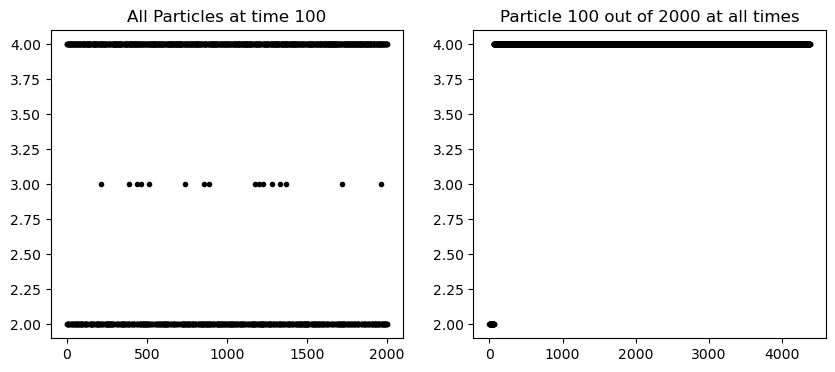

In [13]:
# check the particles status. See if it's working
fig, ax = plt.subplots(1,2,figsize=(10,4))
i_p = 100
i_t = 100
ax[0].plot(ds1.status[:,i_t], '.k', label='status')
ax[0].set_title('All Particles at time ' + str(i_t))
ax[1].plot(ds1.status[i_p,:], '.k', label='status')
ax[1].set_title('Particle ' + str(i_p) + ' out of ' + str(n) + ' at all times')

(array([[3.790e+02, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         5.800e+02],
        [1.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         6.220e+02],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         6.350e+02],
        ...,
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         1.995e+03],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         1.995e+03],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         1.995e+03]]),
 array([1.        , 1.29999995, 1.60000002, 1.89999998, 2.20000005,
        2.5       , 2.79999995, 3.0999999 , 3.4000001 , 3.70000005,
        4.        ]),
 <a list of 4380 BarContainer objects>)

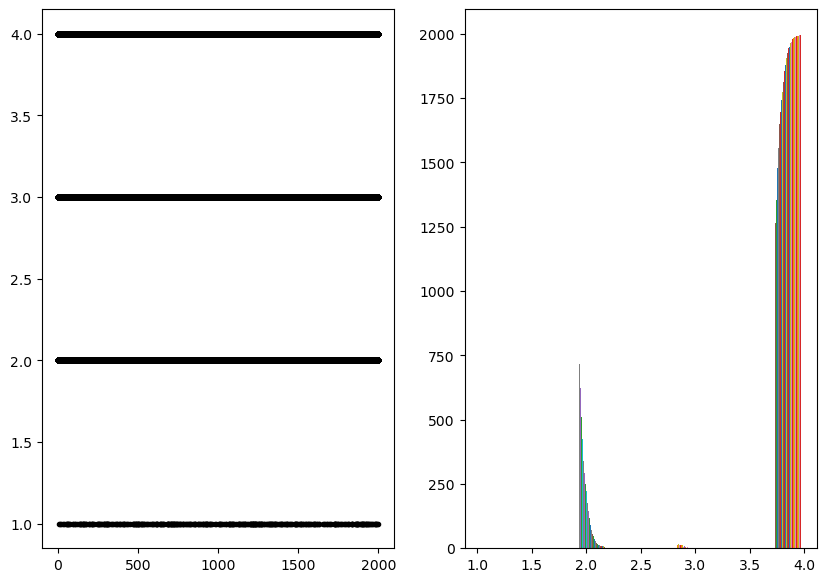

In [14]:
fig, ax = plt.subplots(1,2,figsize=(10,7))
ax[0].plot(ds1.status, '.k', label='status')
#
ax[1].hist(ds1.status)

-States kernel is working ok; it's keeping the initial state for each particle through time.


-Process Kernel it seems to be overwriting the States Kernel, letting particles to change just between status 2 and 3


-PBDEs_forms Kernel is not affecting the other Kernels, since it's just changing a direct property of the particles, not changing their status


Text(0.5, 0.98, 'Particles from Iona Outfall Depths 2022-01-01 00:00:00 to 2022-12-31 00:00:00')

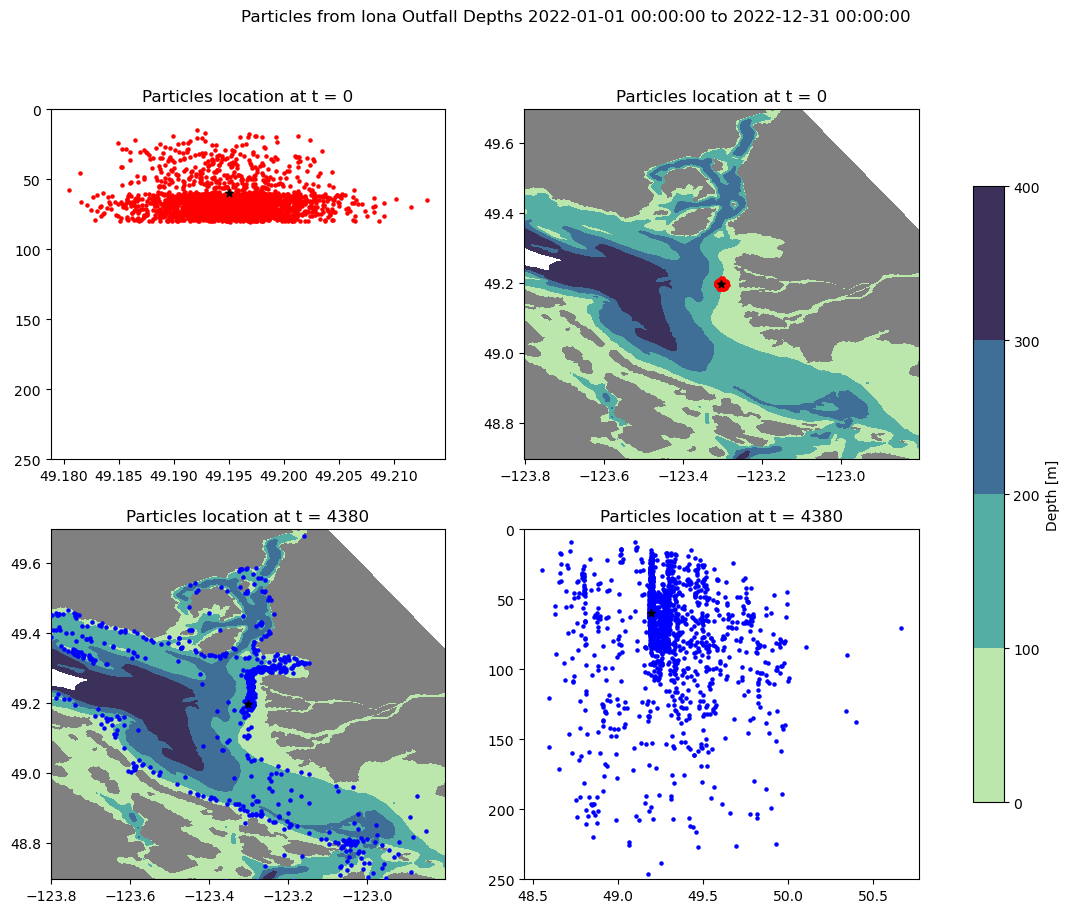

In [15]:
fig,axs=plt.subplots(2,2,figsize=(14,10))

axs[0,0].scatter(ds1.lat[:,0],depth1[:,0],zorder=3,c='r',s=5)
axs[0,0].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=30)
axs[0,0].set_ylim([250,0])
axs[0,0].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[0]))

# Make map
blevels = list(np.arange(0,500,100))

im=axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[0,1].scatter(ds1.lon[:,0],ds1.lat[:,0],zorder=3,c='r',s=5)
axs[0,1].scatter(clon[0],clat[0], zorder=3, c='k', marker='*',s=30)
axs[0,1].set_ylim([clat[0]-.5,clat[0]+.5])
axs[0,1].set_xlim([clon[0]-.5,clon[0]+.5])
axs[0,1].set_title('Particles location at t = 0')

im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(ds1.lon[:,-1],ds1.lat[:,-1],zorder=3,c='b',s=5)
axs[1,0].scatter(clon[0],clat[0], zorder=3, c='k', marker='*',s=30)
axs[1,0].set_ylim([clat[0]-.5,clat[0]+.5])
axs[1,0].set_xlim([clon[0]-.5,clon[0]+.5])
axs[1,0].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[-1]+1))

axs[1,1].scatter(ds1.lat[:,-1],depth1[:,-1],zorder=3,c='b',s=5)
axs[1,1].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=30)
axs[1,1].set_ylim([250,0])
axs[1,1].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[-1]+1))
#
cbar = fig.colorbar(im, ax=axs, location='right', shrink=0.8)
cbar.set_label('Depth [m]')
#
plt.suptitle('Particles from Iona Outfall Depths ' + str(daterange[0]) + ' to ' + str(daterange[-1]))

Text(0.5, 0.98, 'Particles from Iona Outfall Depths 2022-01-01 00:00:00 to 2022-12-31 00:00:00')

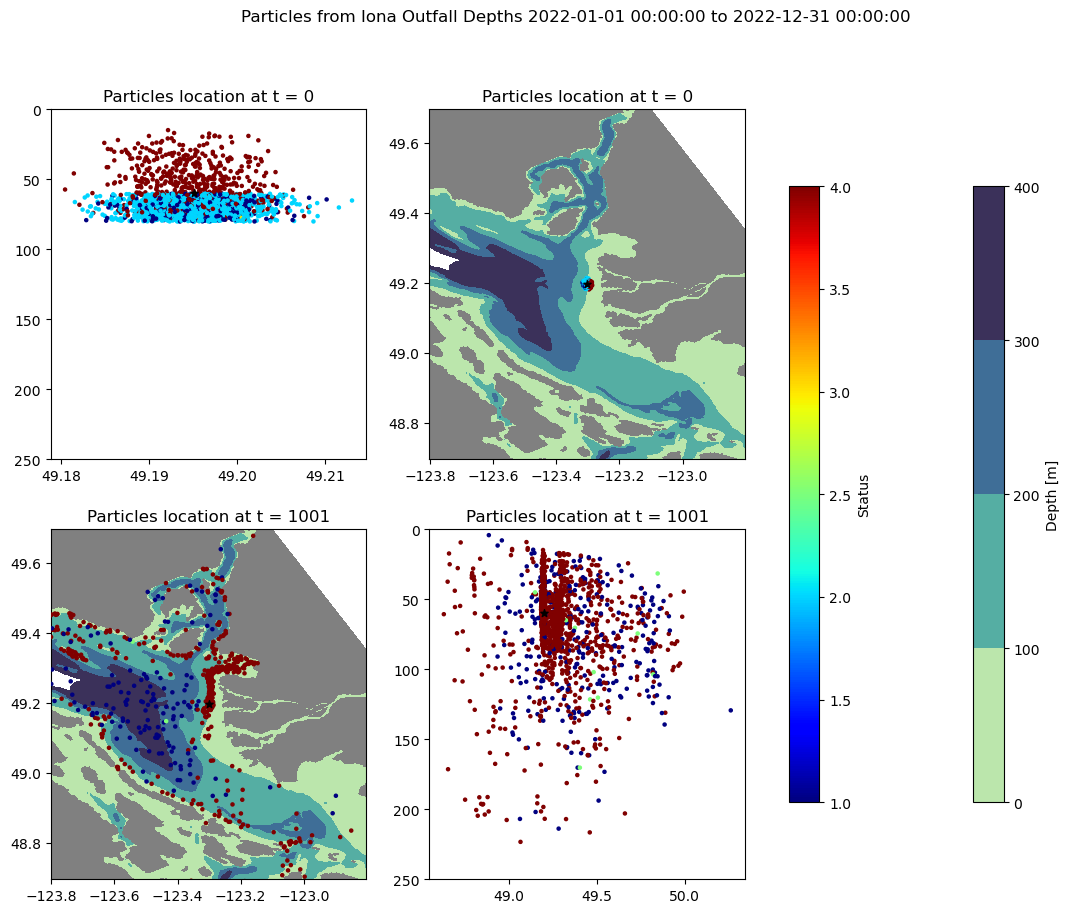

In [16]:
t = 1000
#
fig,axs=plt.subplots(2,2,figsize=(14,10))

pp = axs[0,0].scatter(ds1.lat[:,0],depth1[:,0],zorder=3,c=ds1.status[:,0],s=5, cmap = 'jet')
axs[0,0].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=30)
axs[0,0].set_ylim([250,0])
axs[0,0].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[0]))

# Make map

im=axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[0,1].scatter(ds1.lon[:,0],ds1.lat[:,0],zorder=3,c=ds1.status[:,0],s=5, cmap = 'jet')
axs[0,1].scatter(clon[0],clat[0], zorder=3, c='k', marker='*',s=30)
axs[0,1].set_ylim([clat[0]-.5,clat[0]+.5])
axs[0,1].set_xlim([clon[0]-.5,clon[0]+.5])
axs[0,1].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[0]))

im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(ds1.lon[:,t],ds1.lat[:,t],zorder=3,c=ds1.status[:,t],s=5. , cmap = 'jet')
axs[1,0].scatter(clon[0],clat[0], zorder=3, c='k', marker='*',s=30)
axs[1,0].set_ylim([clat[0]-.5,clat[0]+.5])
axs[1,0].set_xlim([clon[0]-.5,clon[0]+.5])
axs[1,0].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[t]+1))

particles = axs[1,1].scatter(ds1.lat[:,t],depth1[:,t],zorder=3,c=ds1.status[:,t],s=5, cmap = 'jet')
axs[1,1].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=30)
axs[1,1].set_ylim([250,0])
axs[1,1].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[t]+1))
#
cbar = fig.colorbar(im, ax=axs, location='right', shrink=0.8)
cbar.set_label('Depth [m]')
#
cbar1 = fig.colorbar(pp, ax=axs, location='right', shrink=0.8)
cbar1.set_label('Status')
#
plt.suptitle('Particles from Iona Outfall Depths ' + str(daterange[0]) + ' to ' + str(daterange[-1]))

In [17]:
t = 1000

One particle plot / animation

In [18]:
a4 = np.where(ds1.status == 4)
a3 = np.where(ds1.status == 3)
a2 = np.where(ds1.status == 2)
a1 = np.where(ds1.status == 1)

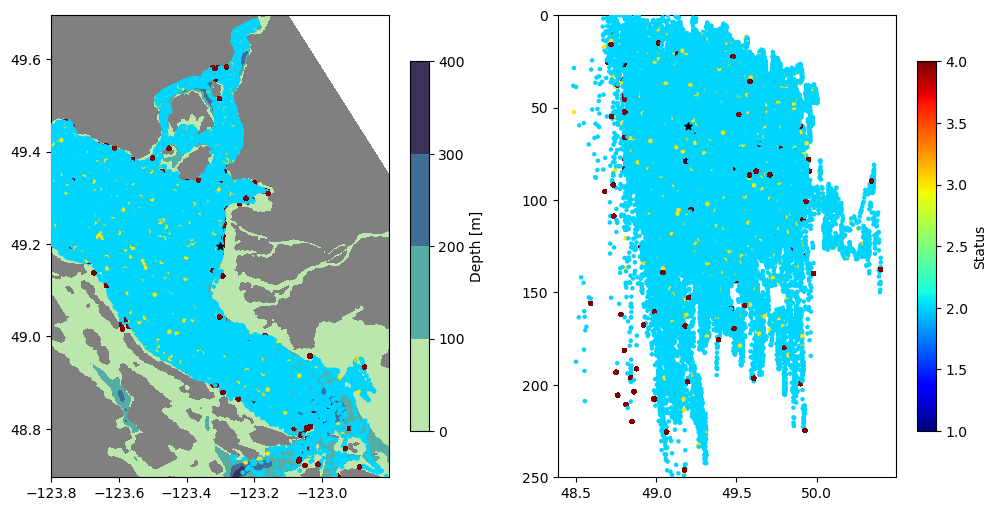

In [19]:
p_num = a1[0]
fig, ax = plt.subplots(1,2,figsize = (12,6))
#
mapita=ax[0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
ax[0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
ax[0].scatter(ds1.lon[p_num,:],ds1.lat[p_num,:],zorder=3,c=ds1.status[p_num,:],s=5. , cmap = 'jet')
ax[0].scatter(clon[0],clat[0], zorder=3, c='k', marker='*',s=30)
ax[0].set_ylim([clat[0]-.5,clat[0]+.5])
ax[0].set_xlim([clon[0]-.5,clon[0]+.5])
#
single = ax[1].scatter(ds1.lat[p_num,:],depth1[p_num,:],zorder=3,c=ds1.status[p_num,:],s=5, cmap = 'jet')
ax[1].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=30)
ax[1].set_ylim([250,0])
#
cbar = fig.colorbar(mapita, ax=ax[0], location='right', shrink=0.8)
cbar.set_label('Depth [m]')
#
cbar1 = fig.colorbar(single, ax=ax[1], location='right', shrink=0.8)
cbar1.set_label('Status')
#

BOTTOM MAPS

In [20]:
aa = np.where(ds1.status[:,-1] == 4)
aa[0]

array([   0,    1,    2, ..., 1997, 1998, 1999])

In [21]:
x, y = finder(ds1.lat[0,0].values, ds1.lon[0,0].values)
print ("The total depth at this location is", mask.totaldepth[x, y].values, 'm', 'and the particle depth is ', ds1.z[0,0].values)

The total depth at this location is 119.5625 m and the particle depth is  72.4060322652654


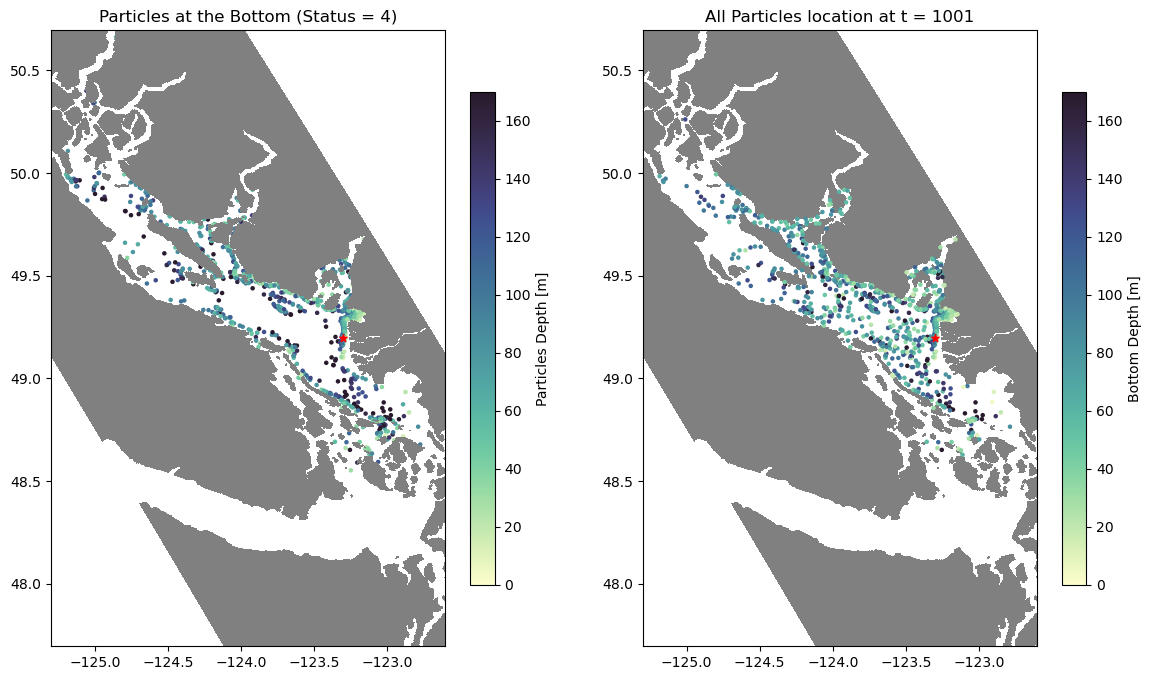

In [24]:
fig, ax = plt.subplots(1,2,figsize=(14,8))
ax[0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
particles = ax[0].scatter(ds1.lon[aa[0], -1], ds1.lat[aa[0], -1], s=5, c=ds1.z[aa[0], -1], cmap = cmap, vmin = 0, vmax = 170)
ax[0].set_ylim([clat[0]-1.5,clat[0]+1.5])
ax[0].set_xlim([clon[0]-2.0,clon[0]+.7])
ax[0].scatter(clon[0],clat[0], zorder=3, c='r', marker='*',s=30)

#ax[0].set_aspect(5/4.4)
ax[0].set_title('Particles at the Bottom (Status = 4)')
#
#bathy=ax[1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap)#,levels=blevels)
ax[1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
all_particles = ax[1].scatter(ds1.lon[:,t],ds1.lat[:,t],zorder=3,s=5, c=ds1.z[:, t], cmap = cmap, vmin = 0, vmax = 170)
ax[1].scatter(clon[0],clat[0], zorder=3, c='r', marker='*',s=30)
ax[1].set_ylim([clat[0]-1.5,clat[0]+1.5])
ax[1].set_xlim([clon[0]-2.0,clon[0]+.7])
ax[1].set_title(f'All Particles location at t = ' + str(ds1.time['obs'].values[t]+1))
#
cbar = fig.colorbar(particles, ax=ax[0], location='right', shrink=0.8)
cbar.set_label('Particles Depth [m]')

#
cbar1 = fig.colorbar(all_particles, ax=ax[1], location='right', shrink=0.8)
cbar1.set_label('Bottom Depth [m]')


In [23]:
print((len(ds1.z[aa[0],-1]) / len(ds1.z[:,-1])) *100, '% of Particles reach the bottom after ', length, ' days of simulation, between ' + str(daterange[0]) + ' and ' + str(daterange[-1]))

99.75 % of Particles reach the bottom after  365  days of simulation, between 2022-01-01 00:00:00 and 2022-12-31 00:00:00


In [33]:
fig, ax = plt.subplots(1,2,figsize=(19, 8))
im = ax[0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
ax[0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
ax[0].scatter(ds1.lon[:, 0], ds1.lat[:, 0],s=2, c='k', cmap = 'jet')
ax[1].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=30)
ax[0].scatter(clon[0],clat[0], zorder=3, c='k', marker='*',s=30)
#ax.legend()
ax[0].set_ylim([clat[0]-.5,clat[0]+.5])
ax[0].set_xlim([clon[0]-.5,clon[0]+.5])
ax[0].set_aspect(5/4.4)
ax[1].set_ylim([250,0])
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].set_title(str(daterange[0]) + ' to ' + str(daterange[-1]))
nmin, nmax = 0, -1
#
cbar = fig.colorbar(im, ax=ax[0], location='right', shrink=0.8)
cbar.set_label('Depth [m]')
#
FFMpegWriter = animation.writers['ffmpeg']  
metadata = dict(title='Animation_Particles', artist='Vicente',
                comment='Particles movement (Year 2022)')
writer = FFMpegWriter(fps=12, metadata=metadata)

with writer.saving(fig, path['anim']+"/Year_run_PBDEs_no_POC.mp4", 100):
    for tm in range(len(ds1.obs)):
        s = ax[0].scatter(ds1.lon[:, nmin:tm], ds1.lat[:, nmin:tm],s=2, c=ds1.status[:,nmin:tm], cmap = 'jet')
        a = ax[1].scatter(ds1.lat[:,nmin:tm],depth1[:,nmin:tm],zorder=3,c=ds1.status[:,nmin:tm],s=5, cmap = 'jet')
        if tm == 0:  # Adding colorbar only once
            a.set_clim(ds1.status.min().values, ds1.status.max().values)
            cb1 = fig.colorbar(a, ax=ax[1])
            cb1.set_label('Status')
        ax[1].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[tm]+1))
        writer.grab_frame()

/tmp/ipykernel_1884726/1869070783.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[0].scatter(ds1.lon[:, 0], ds1.lat[:, 0],s=2, c='k', cmap = 'jet')


KeyboardInterrupt: 